# Feedforward Neural Network with PyTorch for the MNIST dataset

Probably, you need GPUs for this notebook

## Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim

## Dataset
First, we load the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) directly from PyTorch, then we inspect it, as well as its elements

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 59963872.65it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 1602769.21it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 14748741.55it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2094155.08it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

We have  60000 train samples
We have  10000 validation/test samples
Type of these elements: <class 'torchvision.datasets.mnist.MNIST'> <class 'torchvision.datasets.mnist.MNIST'>


An example: 


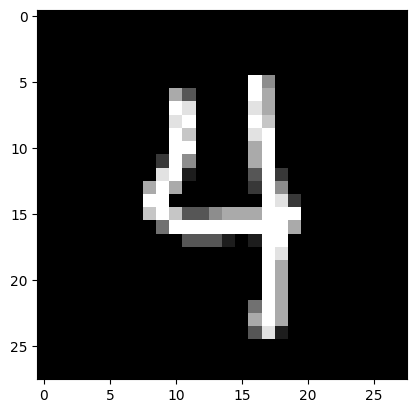

In [2]:
dataset_train = datasets.MNIST('.', train=True, download=True, transform=transforms.ToTensor()) # download = True just once
dataset_test = datasets.MNIST('.', train=False, download=True, transform=transforms.ToTensor())

print("We have ", len(dataset_train), "train samples")
print("We have ", len(dataset_test), "validation/test samples")

print("Type of these elements:", type(dataset_train), type(dataset_test))

print("\n")

# Get an item and its class
k = torch.randint(1, len(dataset_train), (1,))
k = int(k)
X, y = dataset_train[k]

# Show just one item
print("An example: ")
plt.imshow(X.squeeze(), cmap="gray")
plt.show()

**Question**: what happens if you remove the `squeeze` function?

Now we perform what we called `dataset_test` in validation and test

In [3]:
dataset_validation, dataset_test = torch.utils.data.random_split(dataset_test, [0.5, 0.5])
print("We have", len(dataset_validation), "items for validation and", len(dataset_test), "items for test")

We have 5000 items for validation and 5000 items for test


We are ready now for the dataloaders

In [4]:
batch_size = 64 # Reduce it in case you need it

train_loader = DataLoader(dataset_train, batch_size=batch_size)
validation_loader = DataLoader(dataset_validation, batch_size=len(dataset_validation))
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test))

## Model

in this part, we want to define the model. In our case, we want to have 2 hidden layers. Input and output dimensions are given by the problem

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, d_1, d_2, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, d_1)
        self.fc2 = nn.Linear(d_1, d_2)
        self.fc3 = nn.Linear(d_2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# Hyperparameters
d_1 = 100
d_2 = 50
model = Model(28*28, d_1, d_2, 10)

In [6]:
print(model)

Model(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


**Question** : After printing the form, you may have noticed that something is missing. What is it?

Yu can print the model weights -- remember that, at the very beginning these are not trained

In [7]:
for key, value in model.state_dict().items():
    print(key, value)

fc1.weight tensor([[ 0.0310, -0.0156, -0.0244,  ...,  0.0181,  0.0181, -0.0336],
        [ 0.0172,  0.0059,  0.0347,  ...,  0.0269,  0.0129,  0.0137],
        [ 0.0217,  0.0326,  0.0279,  ..., -0.0308,  0.0276,  0.0265],
        ...,
        [-0.0008,  0.0004,  0.0340,  ...,  0.0105, -0.0010,  0.0338],
        [-0.0063,  0.0332,  0.0335,  ..., -0.0117, -0.0017, -0.0154],
        [-0.0051,  0.0211,  0.0067,  ...,  0.0174, -0.0086,  0.0252]])
fc1.bias tensor([-1.9823e-02,  2.1458e-06, -1.7164e-02,  6.0589e-03,  1.5022e-02,
         2.1353e-02, -2.3148e-02, -4.8051e-03, -1.0928e-02,  2.0769e-02,
        -5.6489e-03,  1.1951e-03,  1.3545e-02,  1.3265e-02,  2.8451e-02,
         3.0447e-02,  1.6922e-02,  3.4665e-02,  2.3138e-03,  1.2534e-02,
        -1.3947e-02,  2.2217e-02, -1.0587e-02,  2.7777e-02, -3.4534e-02,
         2.1697e-02,  2.0112e-02,  1.8454e-02, -1.4529e-02, -1.2337e-03,
        -9.5531e-03, -3.1118e-02, -2.6242e-02, -2.2063e-02,  2.3815e-02,
         1.4934e-02,  2.8735e-02,  

## Training loop

First, we define Loss and Optimizer

In [8]:
# Hyperparameter!
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

Then, we decide which device we want to use

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

Working on cpu


Lastly, we set a number of epochs and perform standard training loop

In [10]:
n_epochs = 5
train_loss_list = []
validation_loss_list = []
for epoch in range(n_epochs):
    for data, target in train_loader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # You have to flatten the data!
        data = data.reshape(-1,28*28)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
        
    train_loss = loss.item()
    train_loss_list.append(train_loss)
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validation_loader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
             # You have to flatten the data!
            data = data.reshape(-1,28*28)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {train_loss}, Validation loss {validation_loss}")
            validation_loss_list.append(validation_loss)
    

Epoch 1: Train loss: 0.08356747031211853, Validation loss 0.2011154741048813
Epoch 2: Train loss: 0.06154486909508705, Validation loss 0.1420162469148636
Epoch 3: Train loss: 0.05918441712856293, Validation loss 0.1366029977798462
Epoch 4: Train loss: 0.03345062956213951, Validation loss 0.12832820415496826
Epoch 5: Train loss: 0.02126261405646801, Validation loss 0.1186802014708519


**Questions**: 
1. Try to use and not use GPUs: is there any difference?
2. Are we cheating somewher in computing the loss values?
3. Try to play a little bit with the learning rate, using values such as 0.05 or even 0.1. What can you observe?

We do a simple plot of the two loss functions

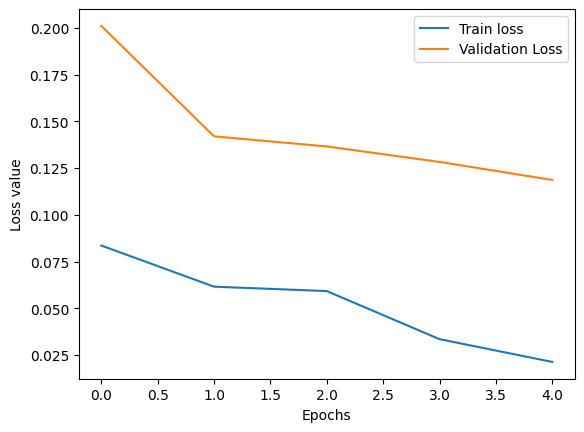

In [11]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

## Test

In this section, we test our model on new data by computing the accuracy

In [12]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        # You have to flatten the data!
        data = data.reshape(-1,28*28)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 96.54 %


## Save & Load models

In [13]:
state = {
    'model_state' : model.state_dict(),
    'optimizer' : optimizer.state_dict()
}
torch.save(state, 'model.pt')

In [14]:
model = Model(28*28, d_1, d_2, 10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
checkpoint = torch.load("model.pt", weights_only=True)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optimizer'])

You loaded a trained model, so it should make good preditcions, let's see

Here we want to predict digit  6


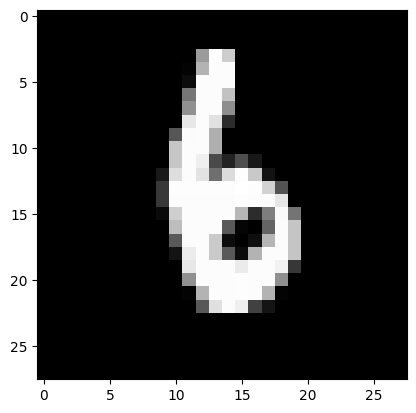


 We predicted tensor([6])


In [15]:
k = torch.randint(1, len(dataset_test), (1,))
k = int(k)
X, y = dataset_test[k]

# Show just one item
print("Here we want to predict digit ", y)
plt.imshow(X.squeeze(), cmap="gray")
plt.show()

data = X.reshape(-1,28*28)
outputs = model(data)
_, predicted = torch.max(outputs.data, 1)

print("\n We predicted", predicted)

**Question**: Do we really need to initialize everything from scratch?